In [ ]:
!pip install --upgrade pip
!pip install 'model-card-toolkit' --use-deprecated=legacy-resolver
!pip install 'tensorflow'
!pip install 'tensorflow-datasets'
!pip install google-cloud-dataplex
!pip install google-cloud-datacatalog

In [ ]:
import tensorflow as tf
import numpy as np
import model_card_toolkit as mct
from model_card_toolkit.documentation.examples import cats_vs_dogs
from model_card_toolkit.utils.graphics import figure_to_base64str
import tempfile
import matplotlib.pyplot as plt
from IPython import display
import requests
import os
import zipfile



from google.cloud import dataplex_v1
from google.cloud import datacatalog_v1


In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

In [ ]:
URL = 'https://storage.googleapis.com/cats_vs_dogs_model/cats_vs_dogs_model.zip'
BASE_PATH = tempfile.mkdtemp()
ZIP_PATH = os.path.join(BASE_PATH, 'cats_vs_dogs_model.zip')
MODEL_PATH = os.path.join(BASE_PATH,'cats_vs_dogs_model')

r = requests.get(URL, allow_redirects=True)
open(ZIP_PATH, 'wb').write(r.content)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH)

model = tf.keras.models.load_model(MODEL_PATH)

In [ ]:
def compute_accuracy(data):
  x = np.stack(data['examples'])
  y = np.asarray(data['labels'])
  _, metric = model.evaluate(x, y)
  return metric

In [ ]:
examples = cats_vs_dogs.get_data()
print('num validation examples:', len(examples['combined']['examples']))
print('num cat examples:', len(examples['cat']['examples']))
print('num dog examples:', len(examples['dog']['examples']))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.MFT4N7_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
num validation examples: 320
num cat examples: 149
num dog examples: 171


In [ ]:
accuracy = compute_accuracy(examples['combined'])
cat_accuracy = compute_accuracy(examples['cat'])
dog_accuracy = compute_accuracy(examples['dog'])

6/6 [==============================] - 2s 367ms/step - loss: 0.1032 - binary_accuracy: 0.9708


In [ ]:
#print(model.summary())
model.save_spec('cats_vs_dogs_model_spec.yaml')
#print(model.inputs.name)

([TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_2')], {})

# Instantiate  Model Card

In [ ]:
# https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/model_card_toolkit.py
model_card_dir = tempfile.mkdtemp()
toolkit = mct.ModelCardToolkit(model_card_dir)

# https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/model_card.py
model_card = toolkit.scaffold_assets()

In [ ]:
model_card.model_details.name = 'Fine-tuned MobileNetV2 Model for Cats vs. Dogs'
model_card.model_details.overview = (
    'This model distinguishes cat and dog images. It uses the MobileNetV2 '
    'architecture (https://arxiv.org/abs/1801.04381) and is trained on the '
    'Cats vs Dogs dataset '
    '(https://www.tensorflow.org/datasets/catalog/cats_vs_dogs). This model '
    'performed with high accuracy on both Cat and Dog images.'
)
model_card.model_details.documentation =('https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/Standalone_Model_Card_Toolkit_Demo.ipynb')

model_card.model_details.owners = [
  mct.Owner(name='Model Cards Team', contact='model-cards@google.com')
]
model_card.model_details.version = mct.Version(name='v1.0', date='08/28/2020')
model_card.model_details.references = [
    mct.Reference(reference='https://www.tensorflow.org/guide/keras/transfer_learning'),
    mct.Reference(reference='https://arxiv.org/abs/1801.04381'),
]
model_card.model_details.licenses = [mct.License(identifier='Apache-2.0')]
model_card.model_details.citations = [mct.Citation(citation='https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/Standalone_Model_Card_Toolkit_Demo.ipynb')]
model_card.model_details.path = ('https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/Standalone_Model_Card_Toolkit_Demo.ipynb')




In [ ]:
model_card.quantitative_analysis.performance_metrics = [
  mct.PerformanceMetric(type='accuracy', value=str(accuracy)),
  mct.PerformanceMetric(type='accuracy', value=str(cat_accuracy), slice='cat'),
  mct.PerformanceMetric(type='accuracy', value=str(dog_accuracy), slice='Dog'),
]

In [ ]:
model_card.considerations.use_cases = [
    mct.UseCase(description='This model classifies images of cats and dogs.')
]
model_card.considerations.limitations = [
    mct.Limitation(description='This model is not able to classify images of other classes.')
]
model_card.considerations.ethical_considerations = [mct.Risk(
    name=
        'While distinguishing between cats and dogs is generally agreed to be '
        'a benign application of machine learning, harmful results can occur '
        'when the model attempts to classify images that don’t contain cats or '
        'dogs.',
    mitigation_strategy=
        'Avoid application on non-dog and non-cat images.'
)]

In [ ]:
# Validation Set Size Bar Chart
fig, ax = plt.subplots()
width = 0.75
rects0 = ax.bar(0, len(examples['combined']['examples']), width, label='Overall')
rects1 = ax.bar(1, len(examples['cat']['examples']), width, label='Cat')
rects2 = ax.bar(2, len(examples['dog']['examples']), width, label='Dog')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Overall', 'Cat', 'Dog'])
ax.set_ylabel('Validation Set Size')
ax.set_xlabel('Slices')
ax.set_title('Validation Set Size for Slices')
validation_set_size_barchart = figure_to_base64str(fig)

In [ ]:
# Acuracy Bar Chart
fig, ax = plt.subplots()
width = 0.75
rects0 = ax.bar(0, accuracy, width, label='Overall')
rects1 = ax.bar(1, cat_accuracy, width, label='Cat')
rects2 = ax.bar(2, dog_accuracy, width, label='Dog')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Overall', 'Cat', 'Dog'])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Slices')
ax.set_title('Accuracy on Slices')
accuracy_barchart = figure_to_base64str(fig)

In [ ]:
model_card.model_parameters.data.append(mct.Dataset())
model_card.model_parameters.data[0].graphics.collection = [
  mct.Graphic(name='Validation Set Size', image=validation_set_size_barchart),
]
model_card.quantitative_analysis.graphics.collection = [
  mct.Graphic(name='Accuracy', image=accuracy_barchart),
]

In [ ]:
toolkit.update_model_card(model_card)

In [ ]:
# Generate a model card document in HTML (default)
html_doc = toolkit.export_format()

# Display the model card document in HTML
display.display(display.HTML(html_doc))

# Register in Model Registry (optional)

# Instantiate Dataplex

## Create an Custom Entry Group

In [ ]:
from google.cloud import dataplex_v1


client = dataplex_v1.CatalogServiceAsyncClient()

# Initialize request argument(s)
request = dataplex_v1.CreateEntryGroupRequest(
parent="projects/dataplex-shared-project-1/locations/us-central1",
entry_group_id="custom-ai-models",
)

# Make the request
operation = client.create_entry_group(request=request)
print("Waiting for operation to complete...")
response = (await operation).result()

# Handle the response
print(response)


## Delete an Entry

In [ ]:
from google.cloud import dataplex_v1

async def sample_delete_entry():
    # Create a client
    client = dataplex_v1.CatalogServiceAsyncClient()

    # Initialize request argument(s)
    request = dataplex_v1.DeleteEntryRequest(
        name="projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom-ai-models/entries/cats-vs-dogs-model",
    )

    # Make the request
    response = await client.delete_entry(request=request)

    # Handle the response
    print(response)

await sample_delete_entry()

name: "projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom-ai-models/entries/cats-vs-dogs-model"
entry_type: "projects/1044414212771/locations/us-central1/entryTypes/custom-ai-model"
create_time {
  seconds: 1723671697
  nanos: 510833000
}
update_time {
  seconds: 1723671902
  nanos: 987887000
}
entry_source {
  system: "COLAB NOTEBOOKS"
  platform: "Local"
  display_name: "Cats-vs-Dogs Custom Model"
  description: "This custom catalog entry represents a custom ai model that was build using this Colab Notebooks(https://colab.research.google.com/drive/117d6YpYRl7ycpKXsw5vC1c6rgKLmhjVR?usp=sharing)"
  location: "us-central1"
}



## Collect Metadata

In [ ]:
from requests import get
from socket import gethostname, gethostbyname
ip = gethostbyname(gethostname()) # 172.28.0.12
fileId = get(f"http://{ip}:9000/api/sessions").json()[0]["path"].split("=")[1]
current_notebook_path="https://colab.research.google.com/drive/"+fileId+"?usp=sharing"



## Create an Entry Using Dataplex API

In [ ]:
# Create a client
client = dataplex_v1.CatalogServiceAsyncClient()

# Initialize request argument(s)
entry = dataplex_v1.Entry()
entry.entry_type = "projects/dataplex-shared-project-1/locations/us-central1/entryTypes/custom-ai-model"
entry_source=dataplex_v1.EntrySource()
entry_source.system="COLAB NOTEBOOKS"
entry_source.platform="Local"
entry_source.display_name=model_card.model_details.name

entry_source.description="This custom catalog entry represents a custom ai model that was build using this Colab Notebooks(" + current_notebook_path+ ")"

#entry.fully_qualified_name="colab_notebooks:model:dataplex-shared-project-1.us-central1.642722820551333128.1"
entry.entry_source=entry_source

request = dataplex_v1.CreateEntryRequest(
        parent="projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom-ai-models",
        entry_id="cats-vs-dogs-model",
        entry=entry,


)

    # Make the request
response = await client.create_entry(request=request)

# Handle the response
print(response)

name: "projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom-ai-models/entries/cats-vs-dogs-model"
entry_type: "projects/dataplex-shared-project-1/locations/us-central1/entryTypes/custom-ai-model"
create_time {
  seconds: 1723671909
  nanos: 867940000
}
update_time {
  seconds: 1723671909
  nanos: 867940000
}
entry_source {
  system: "COLAB NOTEBOOKS"
  platform: "Local"
  display_name: "Fine-tuned MobileNetV2 Model for Cats vs. Dogs"
  description: "This custom catalog entry represents a custom ai model that was build using this Colab Notebooks(https://colab.research.google.com/drive/117d6YpYRl7ycpKXsw5vC1c6rgKLmhjVR?usp=sharing)"
  location: "us-central1"
}



## Create an Entry Using Data Catalog API


In [ ]:
# prompt: Create a custom entry using Data Catalog APIs

# Instantiate Data Catalog
client = datacatalog_v1.DataCatalogClient()

# Initialize request argument(s)
request = datacatalog_v1.CreateEntryRequest(
    parent="projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom_ai_model",
    entry_id="cats_vs_dogs_model_datacatalog",
    entry=datacatalog_v1.Entry(
        name="Custom AI Model",
        description="This custom catalog entry represents a custom ai model that was build using this Colab Notebooks(" + current_notebook_path+ ")",
        user_specified_system="colab_notebooks",
        user_specified_type="custom_ai_model",
        linked_resource=current_notebook_path,
    ),
)

# Make the request
response = client.create_entry(request=request)

# Handle the response
print(response)


name: "projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom_ai_model/entries/cats_vs_dogs_model_datacatalog"
description: "This custom catalog entry represents a custom ai model that was build using this Colab Notebooks(https://colab.research.google.com/drive/117d6YpYRl7ycpKXsw5vC1c6rgKLmhjVR?usp=sharing)"
linked_resource: "https://colab.research.google.com/drive/117d6YpYRl7ycpKXsw5vC1c6rgKLmhjVR?usp=sharing"
user_specified_type: "custom_ai_model"
user_specified_system: "colab_notebooks"



## Attach Aspect

name: "projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom-ai-models/entries/cats-vs-dogs-model"
entry_type: "projects/dataplex-shared-project-1/locations/us-central1/entryTypes/custom-ai-model"
create_time {
  seconds: 1723671909
  nanos: 867940000
}
update_time {
  seconds: 1723770721
  nanos: 856135000
}
aspects {
  key: "dataplex-shared-project-1.us-central1.model-card"
  value {
    aspect_type: "projects/dataplex-shared-project-1/locations/us-central1/aspectTypes/model-card"
    create_time {
      seconds: 1723770721
      nanos: 850696000
    }
    update_time {
      seconds: 1723770721
      nanos: 850696000
    }
    data {
      fields {
        key: "model-card"
        value {
          string_value: "<!DOCTYPE html>\n\n\n\n\n\n\n\n\n\n\n\n<html lang=\"en\">\n<head>\n<style>\n  h1 {text-align: center;}\n  .row {\n    display: flex;\n  }\n  .col {\n    flex: 1;\n  }\n  .card {\n    padding: 1em;\n    border: 1px solid #DADCE0;\n    margin: 10px;\n  
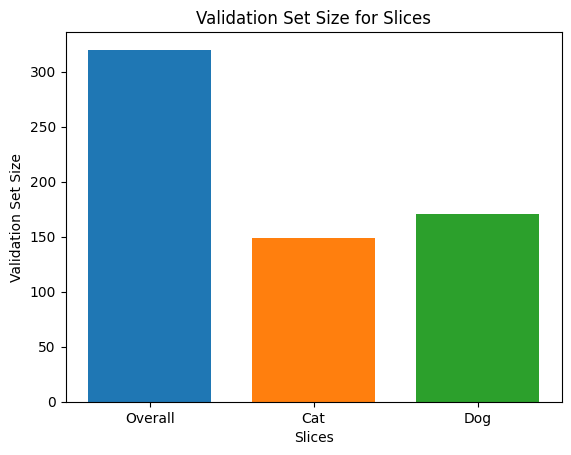
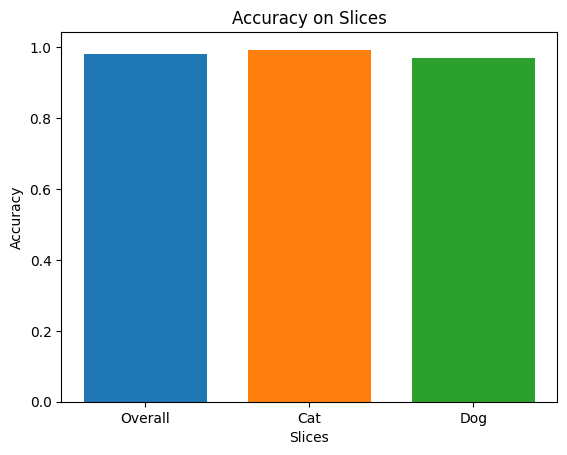

In [ ]:
# prompt: code to attach aspect to an entry dataplex
from google.protobuf import field_mask_pb2
# Create a client
client = dataplex_v1.CatalogServiceAsyncClient()

# Initialize request argument(s)
aspect = dataplex_v1.Aspect()
aspect.aspect_type = "projects/dataplex-shared-project-1/locations/us-central1/aspectTypes/model-card"

model_data = {
    "model-card": html_doc,
    # Add other fields as needed
}

aspect_map = {}
key_direct = f"dataplex-shared-project-1.us-central1.model-card"
aspect.data=model_data
#aspect.metadata.fields["model_name"].string_value = "Cats vs. Dogs"
#aspect.metadata.fields["model_version"].string_value = "v1.0"
from google.protobuf import json_format

aspect_map[key_direct] =  aspect


request = dataplex_v1.UpdateEntryRequest(
    entry=dataplex_v1.Entry(
        name="projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom-ai-models/entries/cats-vs-dogs-model",
        #aspects=list(aspect_map.values())
        aspects=aspect_map
    ),
    update_mask=field_mask_pb2.FieldMask(
        paths=["aspects"]
    ),
)

# Make the request
response = await client.update_entry(request=request)

# Handle the response
print(response)


## Attach Business Overview Aspect

name: "projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom-ai-models/entries/cats-vs-dogs-model"
entry_type: "projects/1044414212771/locations/us-central1/entryTypes/custom-ai-model"
create_time {
  seconds: 1723671909
  nanos: 867940000
}
update_time {
  seconds: 1723742767
  nanos: 23708000
}
aspects {
  key: "dataplex-types.global.overview"
  value {
    aspect_type: "projects/dataplex-types/locations/global/aspectTypes/overview"
    create_time {
      seconds: 1723677194
      nanos: 564755000
    }
    update_time {
      seconds: 1723742767
      nanos: 17039000
    }
    data {
      fields {
        key: "content"
        value {
          string_value: "<!DOCTYPE html>\n\n\n\n\n\n\n\n\n\n\n\n<html lang=\"en\">\n<head>\n<style>\n  h1 {text-align: center;}\n  .row {\n    display: flex;\n  }\n  .col {\n    flex: 1;\n  }\n  .card {\n    padding: 1em;\n    border: 1px solid #DADCE0;\n    margin: 10px;\n  }\n  .img-container {\n    display: flex;\n    flex-w
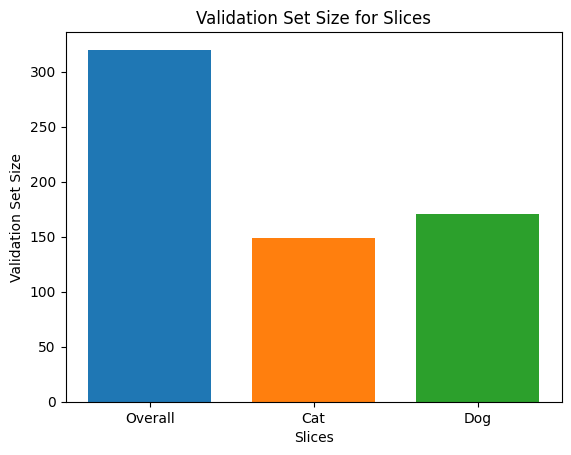
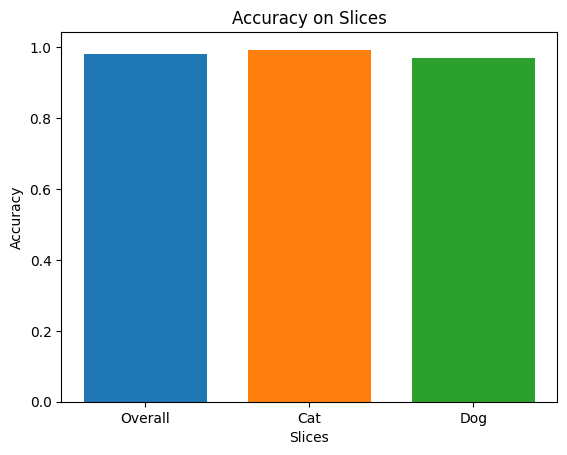

In [ ]:
# Attach aspect to an entry

# prompt: code to attach aspect to an entry dataplex
from google.protobuf import field_mask_pb2
# Create a client
client = dataplex_v1.CatalogServiceAsyncClient()

# Initialize request argument(s)
aspect = dataplex_v1.Aspect()
aspect.aspect_type = "projects/dataplex-types/locations/global/aspectTypes/overview"

overview_data = {
    "content": html_doc,  # Model Card HTML Card
    # Add other fields as needed
}

aspect_map = {}
key_direct = f"dataplex-types.global.overview"
aspect.data=overview_data
#aspect.metadata.fields["model_name"].string_value = "Cats vs. Dogs"
#aspect.metadata.fields["model_version"].string_value = "v1.0"
from google.protobuf import json_format

aspect_map[key_direct] =  aspect


request = dataplex_v1.UpdateEntryRequest(
    entry=dataplex_v1.Entry(
        name="projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom-ai-models/entries/cats-vs-dogs-model",
        #aspects=list(aspect_map.values())
        aspects=aspect_map
    ),
    update_mask=field_mask_pb2.FieldMask(
        paths=["aspects"]
    ),
)

# Make the request
response = await client.update_entry(request=request)

# Handle the response
print(response)


## Create Aspect Type

In [ ]:
from google.cloud import dataplex_v1

async def sample_create_aspect_type():
    # Create a client
    client = dataplex_v1.CatalogServiceAsyncClient()

    # Initialize request argument(s)
    aspect_type = dataplex_v1.AspectType()
    aspect_type.metadata_template.name = "test"
    aspect_type.metadata_template.type_ = "record"
    aspect_type.metadata_template.index=1

     # Define fields within the record
    rec_aspect_type = dataplex_v1.AspectType().MetadataTemplate()

    rec_aspect_type.name = "model_date"
    rec_aspect_type.type_ = "string"
    rec_aspect_type.index = 1

    rec_aspect_type_constraints = dataplex_v1.AspectType.MetadataTemplate.Constraints()
    rec_aspect_type_constraints.required = False
    rec_aspect_type.constraints = rec_aspect_type_constraints


    aspect_type.metadata_template.record_fields = [rec_aspect_type]

    request = dataplex_v1.CreateAspectTypeRequest(
        parent="projects/dataplex-shared-project-1/locations/us-central1",
        aspect_type_id="model-card--model-details",
        aspect_type=aspect_type,
    )


    # Make the request
    operation = client.create_aspect_type(request=request)

    print("Waiting for operation to complete...")

    response = (await operation).result()

    # Handle the response
    print(response)


await sample_create_aspect_type()

Waiting for operation to complete...
<coroutine object AsyncFuture.result at 0x7931eca63990>


<ipython-input-71-1ea1d9e70db8>:59: RuntimeWarning: coroutine 'AsyncFuture.result' was never awaited
  await sample_create_aspect_type()


# Enter Model Overview into Entry Overview

In [ ]:
from google.cloud import dataplex_v1

from google.cloud import datacatalog_v1

entry_overview=datacatalog_v1.EntryOverview()
entry_overview.overview=model_card.model_details.overview

dc_client = datacatalog_v1.DataCatalogClient()




def sample_modify_entry_overview():
    # Create a client
    client = datacatalog_v1.DataCatalogClient()

    # Initialize request argument(s)
    request = datacatalog_v1.ModifyEntryOverviewRequest(
        name="projects/dataplex-shared-project-1/locations/us-central1/entryGroups/custom_ai_model/entries/cats_vs_dogs_model_datacatalog",
        entry_overview=entry_overview,
    )

    # Make the request
    response = client.modify_entry_overview(request=request)

    # Handle the response
    print(response)

sample_modify_entry_overview()



overview: "This model distinguishes cat and dog images. It uses the MobileNetV2 architecture (https://arxiv.org/abs/1801.04381) and is trained on the Cats vs Dogs dataset (https://www.tensorflow.org/datasets/catalog/cats_vs_dogs). This model performed with high accuracy on both Cat and Dog images."

